<a href="https://colab.research.google.com/github/FranciscaAlliende/APS-Failure-at-Scania-Trucks/blob/master/Cost_Sentive_Learning_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AFai4dgKrGr8m5dD9quv6UvjT1lczoDdLtPmC5OWVSf9mxNljCfymY
Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [3]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 5.0MB/s 
     |████████████████████████████████| 6.8MB 9.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# my libraries
import basic_prepro as bp
import null_values as nv
import evaluation_metrics as em

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# import data
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_training_set.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_test_set.csv')

In [6]:
# basic prepocessing
train = bp.data_prepro(train)
test = bp.data_prepro(test)

In [7]:
[y_train, X_train, y_test, X_test] = nv.null_values(train, test, t=0.5)

Total cost: 179500
False positives:  0
False negatives:  359
Confusion matrix, without normalization


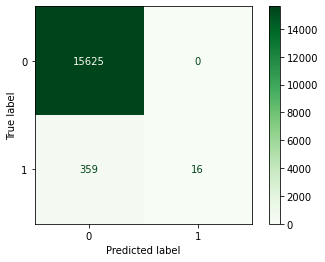

     Normalized confusion matrix


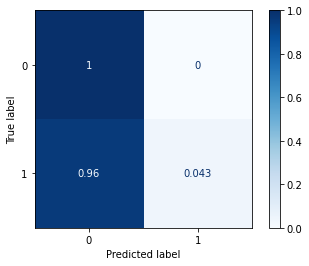

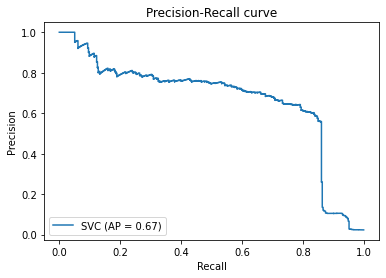

f1 score 0.082
precision:  1.0
recall 0.043


(179500, 0.08184143222506395, 1.0, 0.042666666666666665)

In [8]:
# SVM
clf = SVC(gamma='scale')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
em.evaluation_metrics(y_pred, y_test, X_test, clf, c1=10, c2=500)

Total cost: 18640
False positives:  664
False negatives:  24
Confusion matrix, without normalization


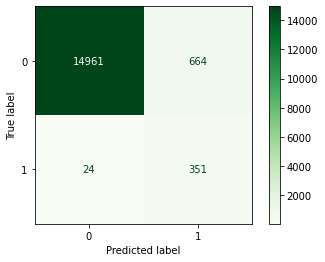

     Normalized confusion matrix


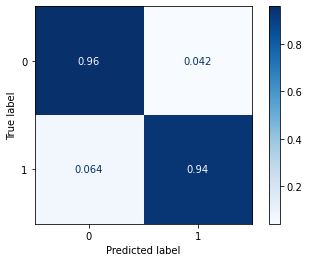

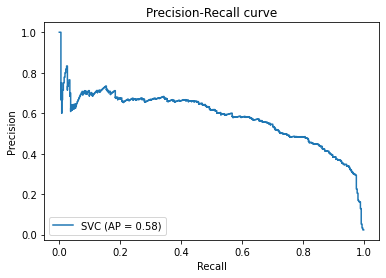

f1 score 0.505
precision:  0.346
recall 0.936


(18640, 0.5050359712230216, 0.3458128078817734, 0.936)

In [9]:
# SVM build-in weighting
clf = SVC(gamma='scale', class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
em.evaluation_metrics(y_pred, y_test, X_test, clf, c1=10, c2=500)

In [10]:
# SVM custom weight
# divide de test set into validation and test
X_test2, X_val, y_test2, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=333)

print(X_val.shape)
print(y_val.shape)
print(X_test2.shape)
print(y_test2.shape)

(5280, 162)
(5280,)
(10720, 162)
(10720,)


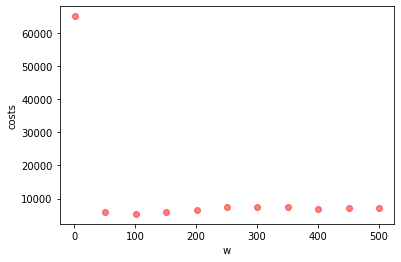

In [14]:
w = 1
ws = []
costs = []

while w < 501:
  clf = SVC(gamma='scale', class_weight={0: 1, 1: w})
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_val)

  tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
  c1 = 10
  c2 = 500
  cost = c1*fp + c2*fn

  ws.append(w)
  costs.append(cost)
  w += 50

plt.scatter(ws, costs, c="r", alpha=0.5)
plt.xlabel("w")
plt.ylabel("costs")
plt.show()

101
Total cost: 13920
False positives:  842
False negatives:  11
Confusion matrix, without normalization


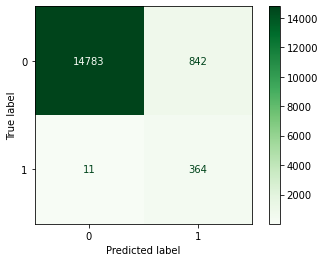

     Normalized confusion matrix


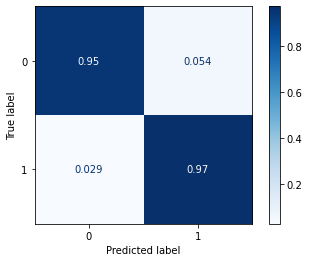

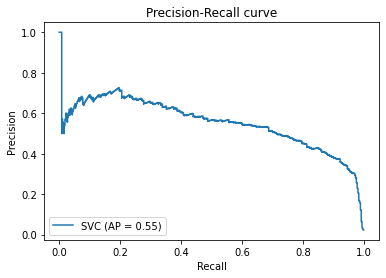

f1 score 0.46
precision:  0.302
recall 0.971


(13920, 0.4604680581910183, 0.3018242122719735, 0.9706666666666667)

In [16]:
w = ws[costs.index(min(costs))]
print(w)
clf = SVC(gamma='scale', class_weight={0: 1, 1: w})
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
em.evaluation_metrics(y_pred, y_test, X_test, clf, c1=10, c2=500)